In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d

In [9]:
# Read the WQ_dataset

data_dir = "/Users/qianqiandu/WQinWI/"

WQ_dataset = pd.read_excel(data_dir + 'Marathon_WQ_Only.xlsx')
WQ_dataset.head()

,organizationidentifier,organizationformalname,monitoringlocationidentifier,monitoringlocationname,monitoringlocationtypename,monitoringlocationdescriptiontex,huceightdigitcode,drainageareameasuremeasurevalue,drainageareameasuremeasureunitco,contributingdrainageareameasurem,...,date,detection_type,resultvalue,detection_limit,unclear_result,bdl,nitrogen_sample,phosphorus_sample,ammonia_sample,fipscode
0,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10008276,Little Rib (North Of) Stewart Ave Site 1,River/Stream,NaN,7070002,NaN,NaN,NaN,...,18786,NaN,0.0610,NaN,0,0,0,0,1,55073
1,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10008379,Plover River Birnawood Rd Site 3,River/Stream,NaN,7070003,NaN,NaN,NaN,...,20668,NaN,0.0475,NaN,0,0,0,0,1,55073
2,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10008431,Comet Creek Sth 153 Site 2,River/Stream,NaN,4030202,NaN,NaN,NaN,...,20676,NaN,0.0423,NaN,0,0,0,1,0,55073
3,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10009368,BULL JUNIOR CREEK UPSTREAM MAPLE RIDGE ROAD - ...,River/Stream,NaN,7070002,NaN,NaN,NaN,...,21409,NaN,0.0247,NaN,0,0,0,0,1,55073
4,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10009487,ARTUS CREEK 25 M UPSTREAM 136 AVE.,River/Stream,NaN,7070002,NaN,NaN,NaN,...,19127,NaN,0.0270,NaN,0,0,0,1,0,55073


In [39]:
# Extract data for just Phosphorus readings 
WQ_subset = WQ_dataset[['resultvalue', "latitudemeasure", "longitudemeasure", "horizontalcoordinatereferencesys", "analysisstartdate", "phosphorus_sample"]]
WQ_subset.head()

Phosphorus = WQ_subset.loc[WQ_subset["phosphorus_sample"] == 1]

Phosphorus.head()

,resultvalue,latitudemeasure,longitudemeasure,horizontalcoordinatereferencesys,analysisstartdate,phosphorus_sample
2,0.0423,44.78378,-89.25829,NAD27,2016-08-19,1
4,0.0270,44.94759,-89.80842,WGS84,2012-05-22,1
5,0.0615,44.91621,-89.90937,WGS84,2015-10-09,1
6,0.0336,44.91596,-89.88928,WGS84,2015-10-09,1
7,0.0865,44.93097,-89.94603,WGS84,2015-10-09,1


In [40]:
Phosphorus['analysisstartdate'] = pd.to_datetime(Phosphorus['analysisstartdate'], format = '%Y-%m-%d')
Phosphorus['year'] = Phosphorus['analysisstartdate'].dt.year
Phosphorus['month'] = Phosphorus['analysisstartdate'].dt.month

/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/1574155325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phosphorus['analysisstartdate'] = pd.to_datetime(Phosphorus['analysisstartdate'], format = '%Y-%m-%d')
/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/1574155325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phosphorus['year'] = Phosphorus['analysisstartdate'].dt.year
/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/1574155325.py:3: SettingWit

In [42]:
# Bin Phosphorus readings every 2 years
Phosphorus.head()

,resultvalue,latitudemeasure,longitudemeasure,horizontalcoordinatereferencesys,analysisstartdate,phosphorus_sample,year,month
2,0.0423,44.78378,-89.25829,NAD27,2016-08-19,1,2016,8
4,0.0270,44.94759,-89.80842,WGS84,2012-05-22,1,2012,5
5,0.0615,44.91621,-89.90937,WGS84,2015-10-09,1,2015,10
6,0.0336,44.91596,-89.88928,WGS84,2015-10-09,1,2015,10
7,0.0865,44.93097,-89.94603,WGS84,2015-10-09,1,2015,10


In [50]:
# Phosphorus['bin_year'] = np.where(Phosphorus['year']<2010, '2009-2010')
Phosphorus['bin'] = 'Unknown'
Phosphorus.loc[Phosphorus['year'].between(2009, 2010, inclusive=False), 'bin'] = '2009-2010'
Phosphorus.loc[Phosphorus['year'].between(2011, 2012, inclusive=True), 'bin'] = '2011-2012'
Phosphorus.loc[Phosphorus['year'].between(2013, 2014, inclusive=True), 'bin'] = '2013-2014'
Phosphorus.loc[Phosphorus['year'].between(2015, 2016, inclusive=True), 'bin'] = '2015-2016'
Phosphorus.loc[Phosphorus['year'].between(2017, 2018, inclusive=True), 'bin'] = '2017-2018'
Phosphorus.loc[Phosphorus['year'].between(2019, 2020, inclusive=True), 'bin'] = '2019-2020'

/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/311813641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phosphorus['bin'] = 'Unknown'
/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/311813641.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  Phosphorus.loc[Phosphorus['year'].between(2009, 2010, inclusive=False), 'bin'] = '2009-2010'
/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/311813641.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  Phosphorus.loc[Phosphorus['year'].between(2011, 2012, inclusive=True), 'bin'] = '2011-2012'
/var/folders/rd/99hdt7y57_g28jbwp_

In [52]:
Phosphorus.head()

,resultvalue,latitudemeasure,longitudemeasure,horizontalcoordinatereferencesys,analysisstartdate,phosphorus_sample,year,month,bin
2,0.0423,44.78378,-89.25829,NAD27,2016-08-19,1,2016,8,2015-2016
4,0.0270,44.94759,-89.80842,WGS84,2012-05-22,1,2012,5,2011-2012
5,0.0615,44.91621,-89.90937,WGS84,2015-10-09,1,2015,10,2015-2016
6,0.0336,44.91596,-89.88928,WGS84,2015-10-09,1,2015,10,2015-2016
7,0.0865,44.93097,-89.94603,WGS84,2015-10-09,1,2015,10,2015-2016


In [56]:
# Phosphorus.to_csv('Phosphorus_subset.csv', index=False)

In [59]:
# Generate geopraphic point data using cords
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the CSV file with latitude and longitude data into a Pandas DataFrame
df = pd.read_csv('/Users/qianqiandu/WQinWI/intermediate_data/Phosphorus_subset.csv')

# Create a new column 'geometry' with Point objects from latitude and longitude columns
df['geometry'] = df.apply(lambda row: Point(row['longitudemeasure'], row['latitudemeasure']), axis=1)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326')

# Save the GeoDataFrame to a shapefile
# gdf.to_file('Phosphorus.shp')


/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/1191399044.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('Phosphorus.shp')


<AxesSubplot:>

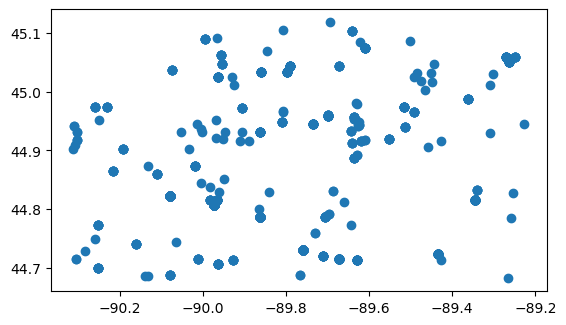

In [63]:
gdf.plot()

In [65]:
# Load the shapefile for the municipal boundaries
municipalities = gpd.read_file('/Users/qianqiandu/WQinWI/MUNIBoundary.shp')

# Load the shapefile to be clipped
data = gpd.read_file('/Users/qianqiandu/WQinWI/Marathon_Watershed_HUC10.shp')

# Perform the clip operation
clipped_data = gpd.clip(data, municipalities)

# Save the clipped data to a new shapefile
clipped_data.to_file('clipped_HUC10.shp')


/var/folders/rd/99hdt7y57_g28jbwp_bbrg0c0000gn/T/ipykernel_59155/396049235.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3071
Right CRS: PROJCS["User_Defined_Lambert_Conformal_Conic",GEOG ...

  clipped_data = gpd.clip(data, municipalities)
/Users/qianqiandu/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


,OBJECTID,WSHED_NAME,PWS_STATUS,NPS_PRIORI,WSHED_CODE,WATERSHED_,WATERSHE_1,TOTAL_STRE,TOTAL_LAKE,TOTAL_WETL,NPS_OVERAL,NPS_OVER_1,NPS_STREAM,NPS_STRE_1,NPS_LAKE_R,NPS_LAKE_1,NPS_GW_RAN,NPS_GW_R_1,geometry
0,393,Upper Eau Claire River,None,0,CW22,141671.72,221.36,0.00,0.00,40234.77,High,The watershed is ranked for overall nonpoint s...,High,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,High,The watershed is ranked for groundwater nonpoi...,"POLYGON ((577015.371 508683.712, 576851.247 50..."
1,397,Upper Rib River,None,0,CW26,126122.31,197.07,0.00,0.00,17127.41,Low,The watershed is ranked for overall nonpoint s...,Low,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,Low,The watershed is ranked for groundwater nonpoi...,"POLYGON ((524300.740 505534.167, 524279.427 50..."
2,409,Copper River,None,0,UW31,65949.36,103.05,187.03,64.93,15346.42,Low,The watershed is ranked for overall nonpoint s...,NR,Not Ranked,Low,The watershed is ranked for lakes nonpoint sou...,Low,The watershed is ranked for groundwater nonpoi...,"POLYGON ((526929.162 515694.305, 526905.255 51..."
3,410,Trappe River,None,0,CW27,64093.40,100.15,0.00,0.00,8389.83,Med,The watershed is ranked for overall nonpoint s...,Low,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,Med,The watershed is ranked for groundwater nonpoi...,"POLYGON ((549525.992 506676.707, 549488.805 50..."
4,413,Devil Creek,None,0,CW28,43837.53,68.50,0.00,0.00,2336.54,High,The watershed is ranked for overall nonpoint s...,Med,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,High,The watershed is ranked for groundwater nonpoi...,"MULTIPOLYGON (((546659.141 506766.716, 546628...."
5,415,Black Creek,None,0,CW25,56665.92,88.54,0.00,0.00,4782.60,High,The watershed is ranked for overall nonpoint s...,High,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,High,The watershed is ranked for groundwater nonpoi...,"POLYGON ((505227.653 507610.109, 505181.247 50..."
6,416,Little Rib River,None,0,CW24,59161.35,92.44,0.00,0.00,2768.75,High,The watershed is ranked for overall nonpoint s...,Med,The watershed is ranked for streams nonpoint s...,NR,Not Ranked,High,The watershed is ranked for groundwater nonpoi...,"POLYGON ((548106.485 495889.391, 548202.859 49..."
7,418,Middle and South Branches Embarrass R,None,0,WR11,160003.33,250.01,273.90,632.66,38496.80,Med,The watershed is ranked for overall nonpoint s...,Low,The watershed is ranked for streams nonpoint s...,NR,Not Ranked,Med,The watershed is ranked for groundwater nonpoi...,"MULTIPOLYGON (((581296.248 479838.530, 581279...."
8,419,Lower Eau Claire (Marathon Co.) River,None,0,CW20,110559.41,172.75,0.00,0.00,7617.54,High,The watershed is ranked for overall nonpoint s...,Med,The watershed is ranked for streams nonpoint s...,Med,The watershed is ranked for lakes nonpoint sou...,High,The watershed is ranked for groundwater nonpoi...,"POLYGON ((569328.278 492886.007, 569309.465 49..."
9,420,Springbrook Creek,I,1994,CW21,44652.66,69.77,99.73,65.96,977.95,High,The watershed is ranked for overall nonpoint s...,High,The watershed is ranked for streams nonpoint s...,Med,The watershed is ranked for lakes nonpoint sou...,High,The watershed is ranked for groundwater nonpoi...,"POLYGON ((577950.049 509092.899, 577948.671 50..."


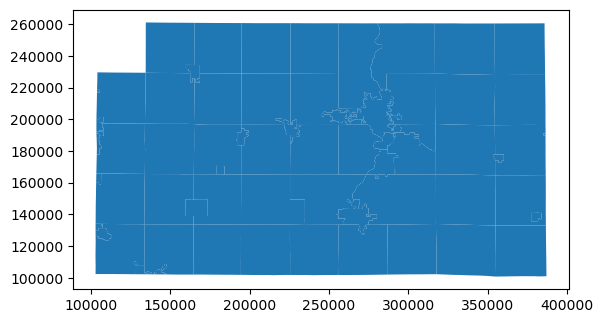